# DeepLIFT property stuff
DeepLIFT explains the difference in the value of a neuron $t$ in terms of the differences of neurons $x_i$. It does this by computing multipliers for each $x_i$, which are defined as the contribution $C_{\Delta{x_i}\Delta{t}}$ divided by the $\Delta{x_i}$. The sums of all the contributions should add up to the difference between the model evaluated at the input and the baseline, which they call the **summation-to-delta** property: 

$$\Delta{t} = \sum_{i = 1}^{n}C_{\Delta{x_i}\Delta{t}} = \sum_{i = 1}^{n}m_{\Delta{x_i}\Delta{t}}\Delta{x_i}$$

The current way I've been calculating importance (using `multiply_by_inputs=False`) is reporting the multipliers for each position, not the contributions. Thus, the summation-to-delta property does not hold if I sum up the scores reported this way. 

In [2]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_style("white")
# sns.set_context("notebook")

from sklearn import preprocessing
import pytorch_lightning as pl
from actpred.models import ActCNNSystem
from actpred.utils import get_threshold, get_stratified_split

from scipy.stats import spearmanr, pearsonr
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger, WandbLogger
from captum.attr import LayerDeepLift
import logomaker
import os
os.chdir("../adhunter")

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in AD data

In [3]:
alphabet="ACDEFGHIKLMNPQRSTVWY"
aa_to_i = {aa:i for i, aa in enumerate(alphabet)}
i_to_aa = {i:aa for i, aa in enumerate(alphabet)}

# load in AD data
fn = "../data/OrthologTilingDFwActivities_20240930_train_test_val.csv"
df = pd.read_csv(fn)
seqs = df.Seq.to_numpy()
activity = df.Activity.to_numpy()
thresh = 80_000
thresh_neg = 50_000
df_ad = df.iloc[np.where(df["Activity"] >= thresh)[0]].copy()
# get binary labels based on threshold
y_bin = (activity >= thresh).astype(np.int64).reshape(-1, 1)
# scale data to have mean 0 and variance 1
y_cont = activity.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(y_cont)
y_cont = scaler.transform(y_cont)
X = np.asarray([[aa_to_i[aa] for aa in x] for x in seqs])
X_ad = torch.tensor(X[np.where(df["Activity"] >= thresh)[0]])
X_neg = torch.tensor(X[np.where(df["Activity"] < thresh_neg)[0]])

# Read in the Gcn4 array data and find the AA sequence of Gcn4 with 
# WLF mutated to A (non-activator) to use as baseline
gcn4_df = pd.read_csv("../data/Gcn4Array_Design.csv", index_col=0)
display(gcn4_df.loc[gcn4_df["Name"].str.contains("GCN4_CAAD40")])
# weak = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_7As_0", "ADseq"].unique().item() # WLF and MFYL > A
gcn4 = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_0", "ADseq"].unique().item()
weak = gcn4_df.loc[gcn4_df["Name"]=="GCN4_CAAD40_WLF_A_0", "ADseq"].unique().item() # WLF only > A

,ADseq,Name,ArrayDNA
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
5,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_MFYL_A_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
6,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_7As_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
3,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
4,STDSTPMFEYENLEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_WLF_A_0,TCTACTGATTCTACTCCAATGTTTGAATATGAGAATTTGGAAGATA...
5,STDSTPAAEAENAEDNSKEWTSLFDNDIPVTTDDVSLADK,GCN4_CAAD40_MFYL_A_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...
6,STDSTPAAEAENAEDNSKEATSAADNDIPVTTDDVSLADK,GCN4_CAAD40_7As_0,TCTACTGATTCTACTCCAGCTGCTGAAGCTGAGAATGCTGAAGATA...


Load in model

In [ ]:
kernel_size = 5
dilation = 3 
hidden = 64

model = ActCNNSystem(hidden, kernel_size, dilation, num_res_blocks=3)
model.load_state_dict(torch.load("adhunter_1he.pt"))
model.eval()

/opt/homebrew/Caskroom/miniconda/base/envs/adhunter/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


ActCNNSystem(
  (model): ActCNN(
    (emb): Linear(in_features=20, out_features=64, bias=False)
    (conv_init): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
    (res_blocks): ModuleList(
      (0-2): 3 x ResBlock(
        (bn_1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_1): ReLU()
        (conv_res): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same, dilation=(3,))
        (bn_2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu_2): ReLU()
        (conv_block): Conv1d(64, 64, kernel_size=(1,), stride=(1,), padding=same)
      )
    )
    (pool): MaxPool1d(kernel_size=40, stride=40, padding=0, dilation=1, ceil_mode=False)
    (lin): Linear(in_features=64, out_features=1, bias=True)
  )
  (loss_fn): MSELoss()
  (rmse): MeanSquaredError()
  (pearsonr): PearsonCorrCoef()
  (spearmanr): SpearmanCorrCoef()
)

## DeepLIFT Baseline Choice

Appendix K of the [DeepLIFT paper](https://arxiv.org/abs/1704.02685) states: 
"*While it may seem natural to use a reference input of all zeros for one-hot encoded inputs, this neglects the fact that
one-hot encoded inputs have the constraint that one of the inputs will always be a 1. For genomics, we suggest using
a reference that is the average of one-hot encoded sequences from the negative set.*"

There's 2 ways of interpreting this. Either go and grab the most common AA at every position based on the one-hot-encoded values of the negative set (in our case, all non-activating 40mers), or average the one-hot-encoded representations across the negative set and use that directly as an input. In the latter case, the baseline would not actually be one-hot-encoded, but would preserve the property that the values for the encoded vectors at each position sum to one. 

In [5]:
baseline_neg = model.model.encode(X_neg).mean(dim=0).unsqueeze(0)
baseline_neg_true_one_hot = model.model.encode(baseline_neg.squeeze().argmax(dim=-1)).unsqueeze(0)

print(f"Model prediction of averaged one-hot-encoded negative set: {model(baseline_neg).item()}")
print(f"Model prediction of true one-hot negative set: {model(baseline_neg_true_one_hot).item()}")

Model prediction of averaged one-hot-encoded negative set: -0.6436503529548645
Model prediction of true one-hot negative set: -0.8136613368988037


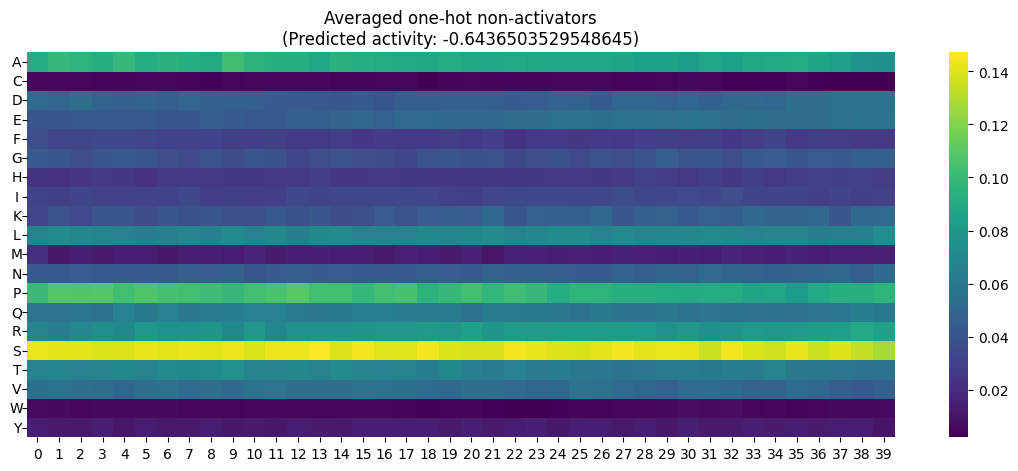

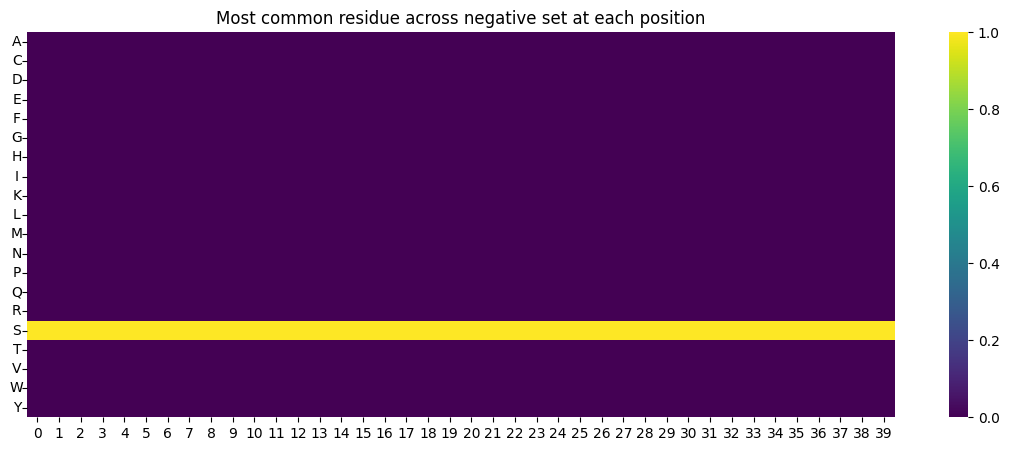

In [6]:
baseline_df = pd.DataFrame(baseline_neg.squeeze()).T
baseline_df.index = list(alphabet)
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(baseline_df, xticklabels=True, cmap='viridis', ax=ax)
ax.set_xticklabels(range(40), ha="center", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
ax.set_title(f"Averaged one-hot non-activators\n(Predicted activity: {model(baseline_neg).item()})")
plt.show()

baseline_df = pd.DataFrame(baseline_neg_true_one_hot.squeeze()).T
baseline_df.index = list(alphabet)
fig, ax = plt.subplots(figsize=(14, 5))
sns.heatmap(baseline_df, xticklabels=True, cmap='viridis', ax=ax)
ax.set_xticklabels(range(40), ha="center", rotation=0)
ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
ax.set_title("Most common residue across negative set at each position")
plt.show()

In our case with the gcn4 data, it seems best to average the one-hot-encoded non-activators and use these values (which aren't one-hot-encoded but still sum to 1 at each position) as the baseline, since taking the most common residue would lead to using a baseline of 40 Serines

## DeepLIFT on ADs vs. non-activating averaged baseline

In [7]:
dl = LayerDeepLift(model, layer=model.model.emb, multiply_by_inputs=True,)
attr = dl.attribute(model.model.encode(X_ad), baseline_neg, attribute_to_layer_input=True)


In [8]:
def get_attr(dl, X, baseline, alphabet="ACDEFGHIKLMNPQRSTVWY"):
    attr = dl.attribute(X, baselines=baseline, attribute_to_layer_input=True).detach().numpy()
    attr_df = pd.DataFrame(attr.mean(axis=0)).T
    attr_df.index = list(alphabet)
    return attr_df

def plot_attr(df, ax=None, title=None, cmap="seismic"):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14,5))
    sns.heatmap(df, cmap=cmap, center=0, ax=ax)
    ax.set_ylabel("AA")
    ax.set_xlabel("Position")
    ax.set_xticklabels(range(40), ha="center", rotation=0)
    ax.set_yticklabels(ax.get_yticklabels(), ha="center", rotation=0)
    if title is not None:
        ax.set_title(title)
    return ax

attr_df = pd.DataFrame(attr.detach().numpy().mean(axis=0)).T
attr_df.index = list(alphabet)

The summation-to-delta property holds for the contribution scores obtained here (although it seems like there's a bit of floating point error)

$$\Delta{t} = \sum_{i = 1}^{n}C_{\Delta{x_i}\Delta{t}}$$

In [9]:
attr_sums = attr.sum(dim=1).sum(dim=1).detach().numpy()
dts = (model(X_ad) - model(baseline_neg)).detach().numpy().flatten()

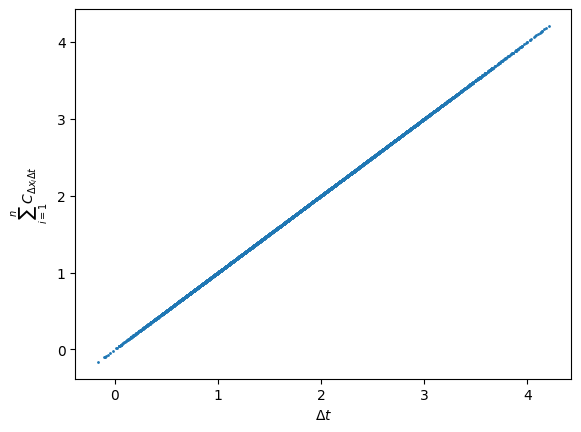

In [10]:
# plt.plot(np.arange(max(dts)), np.arange(max(dts)), c='k', alpha=.5)
plt.scatter(x=dts, y=attr_sums, s=1)
plt.xlabel(r"$\Delta{t}$")
plt.ylabel(r"$\sum_{i = 1}^{n}C_{\Delta{x_i}\Delta{t}}$")
plt.show()

Plot attributions

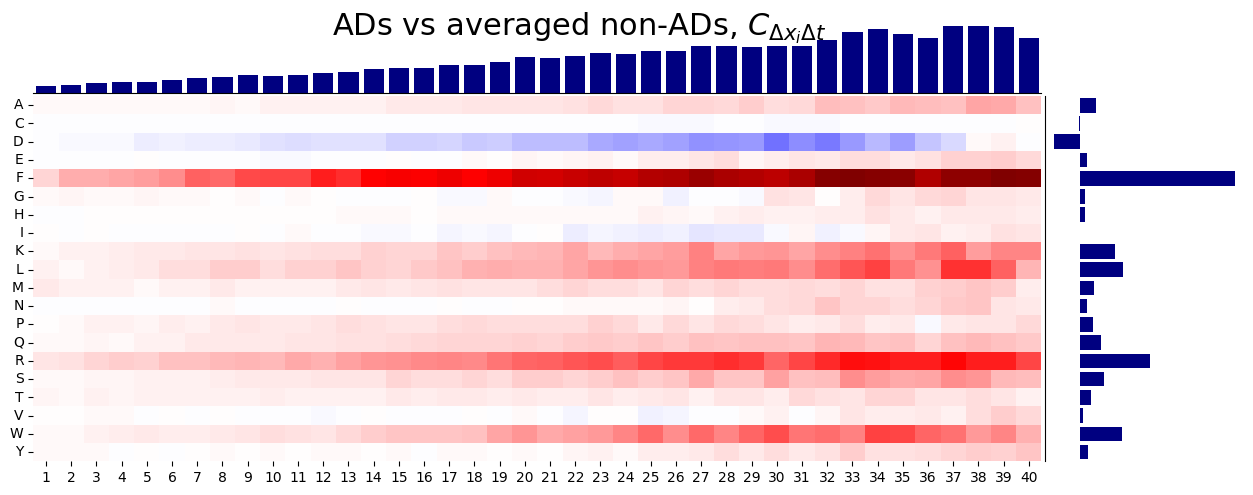

In [11]:
def joint_plot(attr_df, title=""):
    attr_df_melt = (attr_df
                        .rename_axis("AA")
                        .reset_index()
                        .melt(
                            id_vars=['AA'], 
                            var_name='pos', 
                            value_name='val'))

    D = 40
    H = 20
    df_ = attr_df_melt

    g = sns.jointplot(data=df_, x='AA', y='pos', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(
        data=df_['val'].to_numpy().reshape(D, H).T, 
        ax=g.ax_joint, cbar=False, cmap='seismic', 
        center=0)

    g.ax_marg_y.barh(np.arange(0.5, H), df_.groupby(['AA'])['val'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df_.groupby(['pos'])['val'].sum().to_numpy(), color='navy')

    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    g.ax_joint.set_yticks(np.arange(0.5, H))
    g.ax_joint.set_yticklabels(list(alphabet), rotation=0)

    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

    g.fig.set_size_inches(14,5)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    plt.suptitle(title, fontsize=22, y=1)
    plt.show()

joint_plot(attr_df, r"ADs vs averaged non-ADs, $C_{\Delta{x_i}\Delta{t}}$")

If we attribute for a single sequence, generally it looks like importance scores are only high or low in positions corresponding to that sequence's AA at each position, for instance, the gcn4 sequence here:

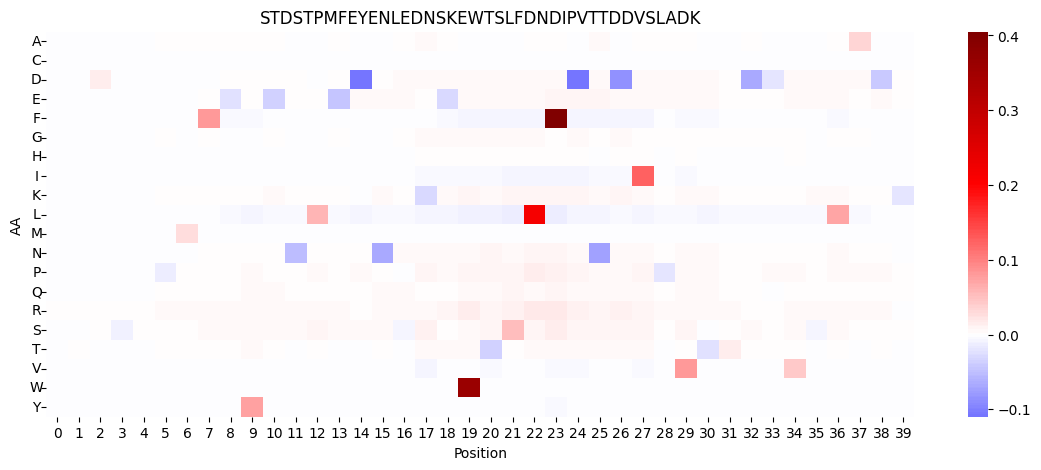

In [12]:
gcn4_attr_null = get_attr(dl, model.model.encode(gcn4), baseline_neg)
plot_attr(gcn4_attr_null, title=gcn4)
plt.show()
# np.where([i == "D" for i in gcn4])

But how is multiply_by_inputs actually working? To test this, let's compare that Gcn4 sequence with the same sequence but with the WLF motif mutated to A's, which we know shouldn't activate:

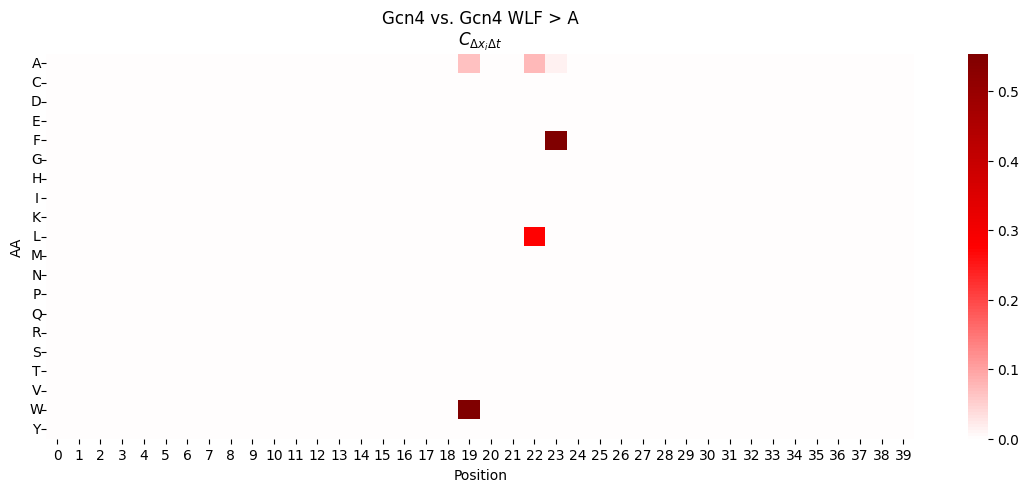

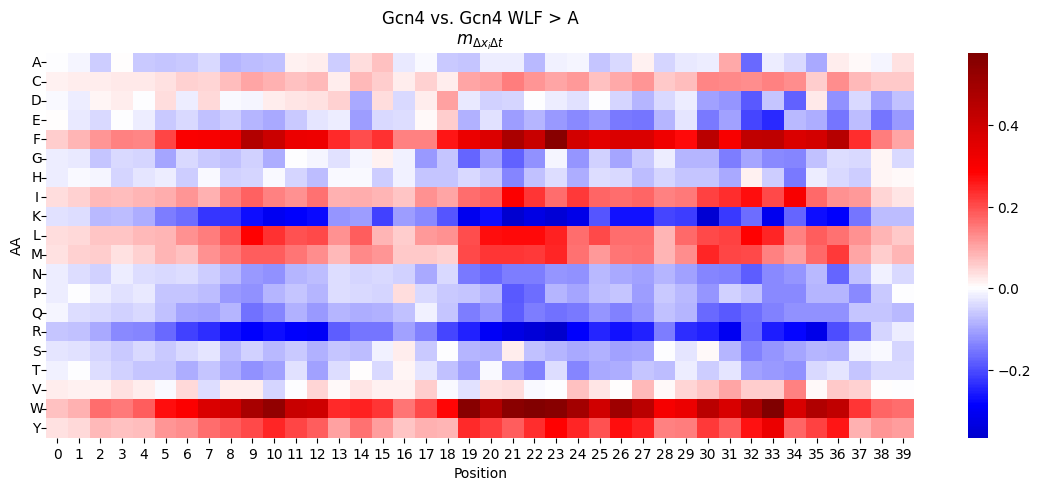

In [13]:
dl_m = LayerDeepLift(model, model.model.emb, multiply_by_inputs=False)
gcn4_enc, weak_enc = model.model.encode(gcn4), model.model.encode(weak)

# comp_title = f"{gcn4}\nvs.\n{weak}\n"
comp_title = "Gcn4 vs. Gcn4 WLF > A\n"
attr_gcn4 = get_attr(dl, gcn4_enc, weak_enc)
plot_attr(attr_gcn4, title=comp_title + r"$C_{\Delta{x_i}\Delta{t}}$")
plt.show()

multipliers = dl_m.attribute(gcn4_enc, weak_enc, attribute_to_layer_input=True).squeeze().detach().numpy()
mdf = pd.DataFrame(multipliers).T
mdf.index = list(alphabet)
plot_attr(mdf, title=comp_title + r"$m_{\Delta{x_i}\Delta{t}}$")
plt.show()

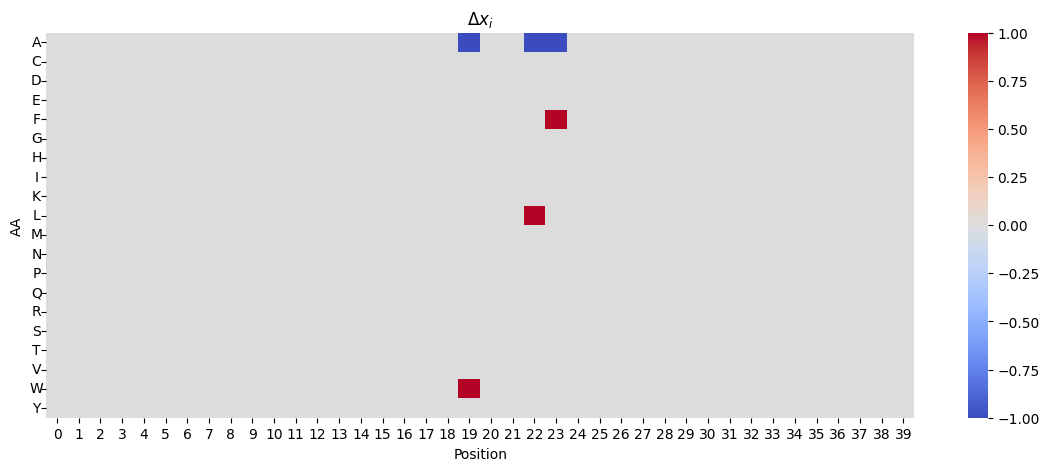

In [14]:
delta_x = (gcn4_enc - weak_enc).squeeze().detach().numpy()
dx_df = pd.DataFrame(delta_x).T
dx_df.index = list(alphabet)
plot_attr(dx_df, title=r"$\Delta{x_i}$", cmap='coolwarm')
plt.show()

Sure enough multiplying $\Delta{x_i}$ by $m_{\Delta{x_i}\Delta{t}}$ at each $x_i$ gives us the original contributions matrix:

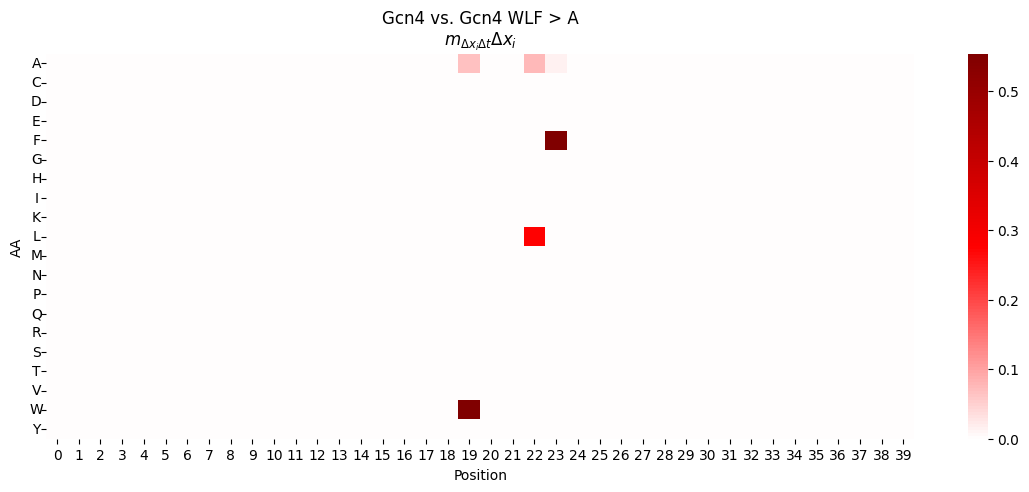

All values match!


In [15]:
c = multipliers * delta_x
cdf = pd.DataFrame(c).T
cdf.index = list(alphabet)
plot_attr(cdf, title=comp_title + "$m_{\Delta{x_i}\Delta{t}}\Delta{x_i}$")
plt.show()

if (cdf == attr_gcn4).values.flatten().all():
    print(r"All values match!")

Notably, the Alanines substituted for the motif have $C_{\Delta{x_i}\Delta{t}} > 0$, and we can see that this is because $\Delta{x_i}, m_{\Delta{x_i}\Delta{t}} < 0$ at these positions. I'd interpret this as meaning that ***Alanines negatively affect activation at these positions, so because gcn4 doesn't have alanines there, its activation is higher.***

In other words, losing these alanines in contrast to the reference sequence increases activation. If both the input and reference are one-hot encoded, multiplying the $m_{\Delta{x_i}\Delta{t}}$ by $|\Delta{x_i}|$ helps us get a better idea of what direction the effects are when a given aa is added somewhere:

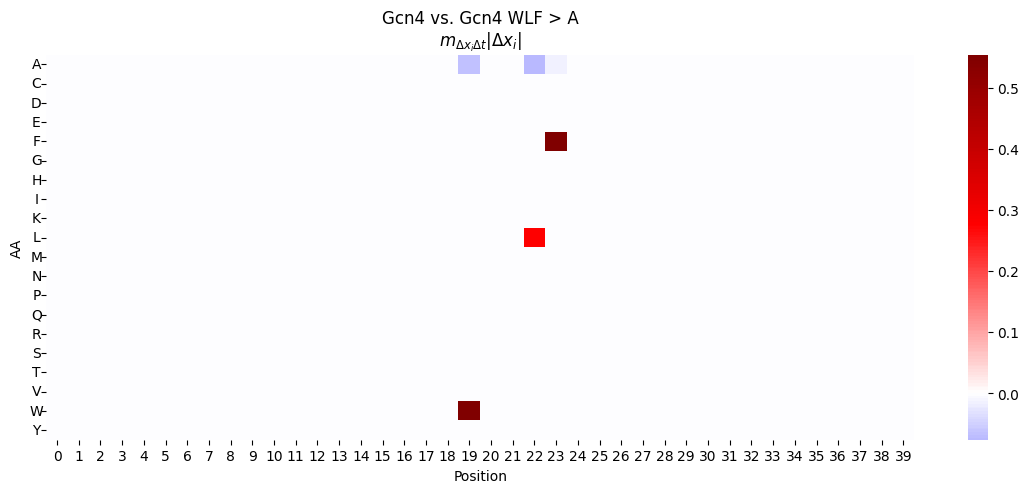

In [16]:
c = multipliers * np.abs(delta_x)
cdf = pd.DataFrame(c).T
cdf.index = list(alphabet)
plot_attr(cdf, title=comp_title + "$m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()

But what if we follow the same procedure comparing to the null baseline? In this case, the values of the baseline matrix are floats at each position instead of 1 or 0

<Axes: title={'center': 'Gcn4 vs average non-activating baseline\n$\\Delta{x_i}$'}, xlabel='Position', ylabel='AA'>

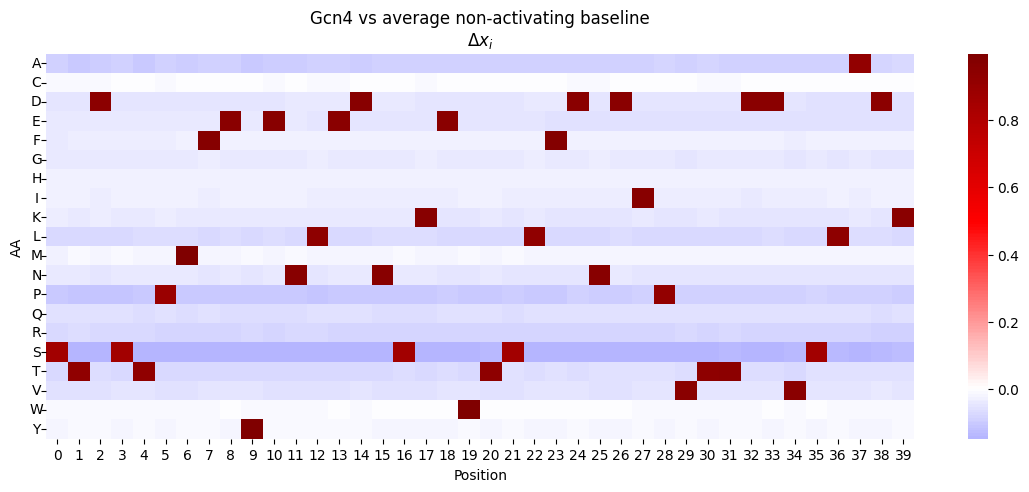

In [17]:
delta_x_null = (gcn4_enc - baseline_neg).squeeze().detach().numpy()
dxn_df = pd.DataFrame(delta_x_null).T
dxn_df.index = list(alphabet)
ctitle = "Gcn4 vs average non-activating baseline\n"
plot_attr(dxn_df, title=ctitle + "$\Delta{x_i}$")

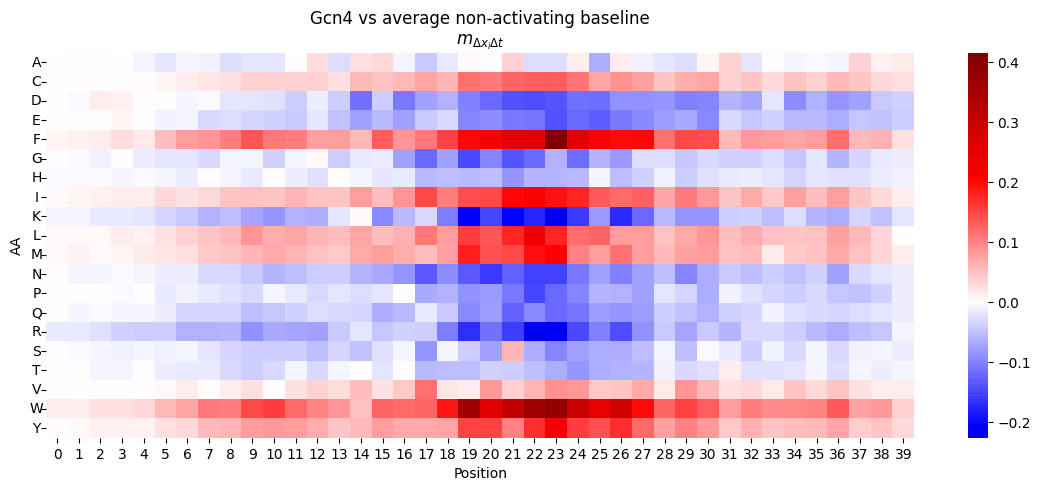

Multipliers * ∆x match contributions


In [18]:
gcn4_mult_null = get_attr(dl_m, gcn4_enc, baseline_neg)
plot_attr(gcn4_mult_null, title=ctitle + "$m_{\Delta{x_i}\Delta{t}}$")
plt.show()

if (gcn4_mult_null.T.values * delta_x_null == gcn4_attr_null.T.values).all():
    print("Multipliers * ∆x match contributions")

This gives a better idea of what direction the effect of having a given residue would be at each position:

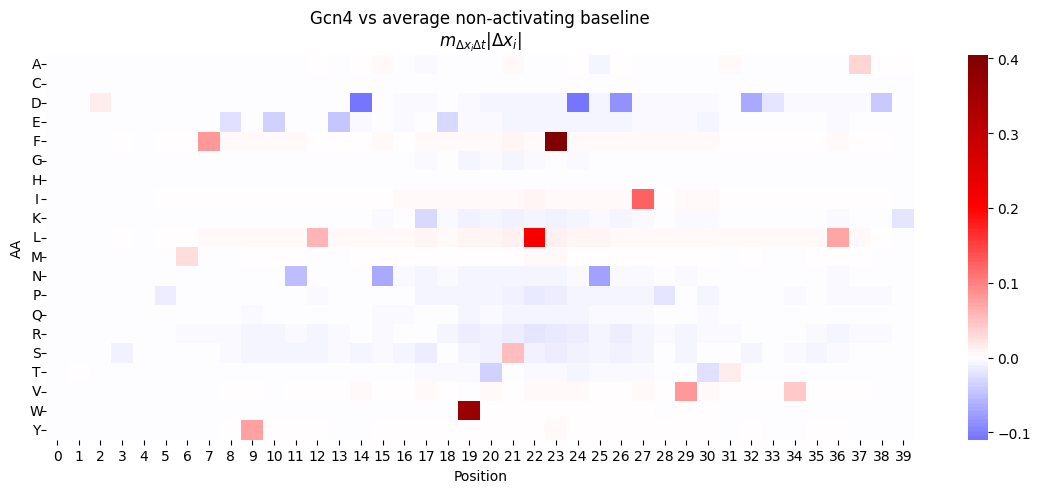

In [19]:
plot_attr(gcn4_mult_null * np.abs(dxn_df), 
          title=ctitle + "$m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()

Let's apply this across all ADs to see directionality of important features:

In [20]:
X_ad_enc = model.model.encode(X_ad)
ad_multipliers = dl_m.attribute(X_ad_enc, baseline_neg, attribute_to_layer_input=True)
# ads_mult_null = get_attr(dl_m, X_ad_enc, baseline_neg)
# X_ad.shape

Let's plot the average value of the multipliers ($\bar{m}_{\Delta{x_i}\Delta{t}}$) across ADs:

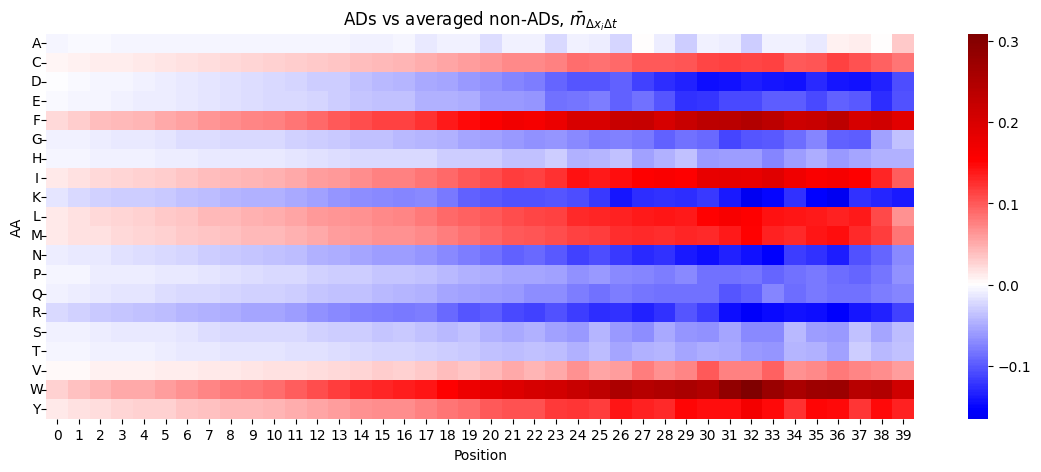

In [21]:
ad_mult_df = pd.DataFrame(ad_multipliers.mean(axis=0)).T
ad_mult_df.index = list(alphabet)
plot_attr(ad_mult_df, title="ADs vs averaged non-ADs, $\\bar{m}_{\Delta{x_i}\Delta{t}}$")
plt.show()

And now multiply each $m_{\Delta{x_i}\Delta{t}}$ by each $|\Delta{x_i}|$, then average across all ADs:

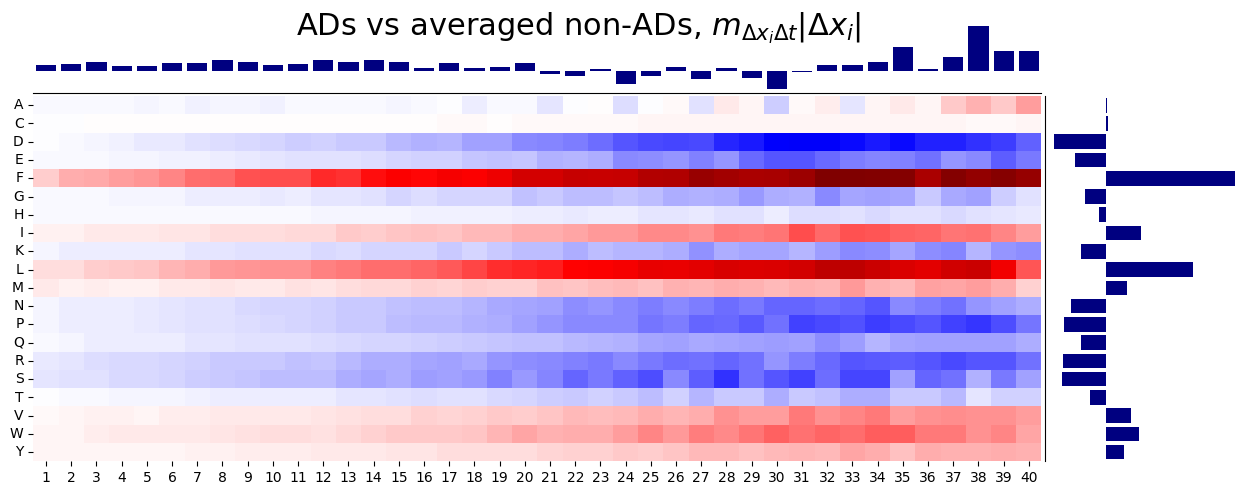

In [22]:
ad_dx = X_ad_enc - baseline_neg
ad_m_abs_dx = ad_multipliers * torch.abs(ad_dx)
mean_attr = ad_m_abs_dx.squeeze().detach().numpy().mean(axis=0)

ad_attr_absdx = pd.DataFrame(mean_attr).T
ad_attr_absdx.index = list(alphabet)
# plot_attr(ad_attr_absdx, title="ADs vs averaged non-ADs, $m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
# plt.show()
joint_plot(ad_attr_absdx, title="ADs vs averaged non-ADs, $m_{\Delta{x_i}\Delta{t}}|\Delta{x_i}|$")
plt.show()
# (()[0] == (ad_multipliers[0] * ad_dx[0])).all()

## Different classifications of ADs

In [23]:
def charge_ctr(seq):
    pos = seq.count("R") + seq.count("K")
    neg = seq.count("D") + seq.count("E")
    return pos - neg

df_ad['charge'] = df_ad["Seq"].apply(charge_ctr)
df_ad['acidic'] = df_ad["charge"] < 0
df_ad["s_rich"] = df_ad["Seq"].apply(lambda x: x.count("S") / 40 >= .15)
df_ad["p_rich"] = df_ad["Seq"].apply(lambda x: x.count("P") / 40 >= .15)

In [24]:
df['charge'] = df["Seq"].apply(charge_ctr)
df['acidic'] = df["charge"] < 0
df["s_rich"] = df["Seq"].apply(lambda x: x.count("S") / 40 >= .15)
df["p_rich"] = df["Seq"].apply(lambda x: x.count("P") / 40 >= .15)

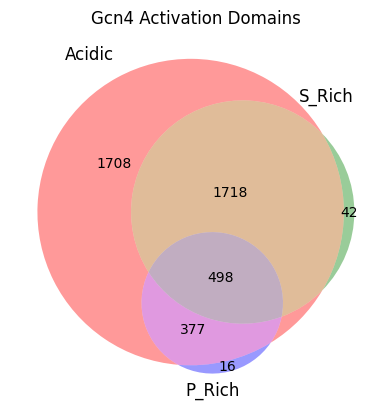

14532


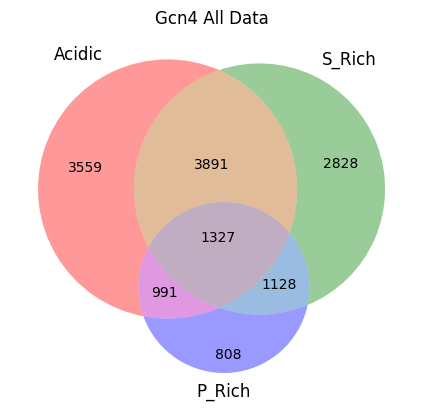

In [25]:
from matplotlib_venn import venn3
acidic = df_ad['acidic']
s_rich = df_ad['s_rich']
p_rich = df_ad['p_rich']

only_acidic = sum([a and not b and not c for a, b, c in zip(acidic, s_rich, p_rich)])
only_s_rich = sum([not a and b and not c for a, b, c in zip(acidic, s_rich, p_rich)])
only_p_rich = sum([not a and not b and c for a, b, c in zip(acidic, s_rich, p_rich)])
acidic_and_s_rich = sum([a and b and not c for a, b, c in zip(acidic, s_rich, p_rich)])
acidic_and_p_rich = sum([a and not b and c for a, b, c in zip(acidic, s_rich, p_rich)])
s_rich_and_p_rich = sum([not a and b and c for a, b, c in zip(acidic, s_rich, p_rich)])
all_three = sum([a and b and c for a, b, c in zip(acidic, s_rich, p_rich)])

# Create the Venn diagram with correct counts
venn3(subsets=(only_acidic, only_s_rich, acidic_and_s_rich, only_p_rich, acidic_and_p_rich, s_rich_and_p_rich, all_three),
      set_labels=('Acidic', 'S_Rich', 'P_Rich'))


# Display the Venn diagram
plt.title("Gcn4 Activation Domains")
plt.show()

acidic = df['acidic']
s_rich = df['s_rich']
p_rich = df['p_rich']

only_acidic = sum([a and not b and not c for a, b, c in zip(acidic, s_rich, p_rich)])
only_s_rich = sum([not a and b and not c for a, b, c in zip(acidic, s_rich, p_rich)])
only_p_rich = sum([not a and not b and c for a, b, c in zip(acidic, s_rich, p_rich)])
acidic_and_s_rich = sum([a and b and not c for a, b, c in zip(acidic, s_rich, p_rich)])
acidic_and_p_rich = sum([a and not b and c for a, b, c in zip(acidic, s_rich, p_rich)])
s_rich_and_p_rich = sum([not a and b and c for a, b, c in zip(acidic, s_rich, p_rich)])
all_three = sum([a and b and c for a, b, c in zip(acidic, s_rich, p_rich)])
print( sum([only_acidic, only_s_rich, only_p_rich, acidic_and_s_rich, acidic_and_p_rich, s_rich_and_p_rich, all_three]))
# Create the Venn diagram with correct counts
venn3(subsets=(only_acidic, only_s_rich, acidic_and_s_rich, only_p_rich, acidic_and_p_rich, s_rich_and_p_rich, all_three),
      set_labels=('Acidic', 'S_Rich', 'P_Rich'))


# Display the Venn diagram
plt.title("Gcn4 All Data")
plt.show()

In [26]:
# seq = "".join(["FD" for _ in range(20)])
# print(model(seq).item())
# plot_attr(get_attr(dl, model.model.encode(seq), baseline_neg))

# joint_plot(get_attr(dl, model.model.encode(seq), baseline_neg))

In [27]:
# from captum.attr import DeepLiftShap

# dls = DeepLiftShap(model)
# get_attr(, X_ad, baseline_neg)
# shap_scores = dls.attribute(model.model.encode(X_ad)[:10], model.model.encode(X_neg))
# baseline_neg



In [28]:
# shap_scores.shape

If I mutate D > A for ADs with D in them, does that always increase predicted score?

**IS ADHUNTER LESS ACCURATE FOR D-CONTAINING ADS? WHAT ARE THE PROPERTIES OF ADS IT FAILS AT?**

In [29]:
df_ad_acidic = df_ad.loc[df_ad["Seq"].str.contains("D")]
X_ad_d = torch.stack(
    df_ad_acidic["Seq"].apply(model.model.encode).tolist()).squeeze()
X_ad_d2a = torch.stack(
    df_ad_acidic["Seq"].str.replace("D", "A").apply(model.model.encode).tolist()).squeeze()
mutated_preds = model(X_ad_d2a).detach().numpy().flatten()
actual_preds = model(X_ad_d).detach().numpy().flatten()

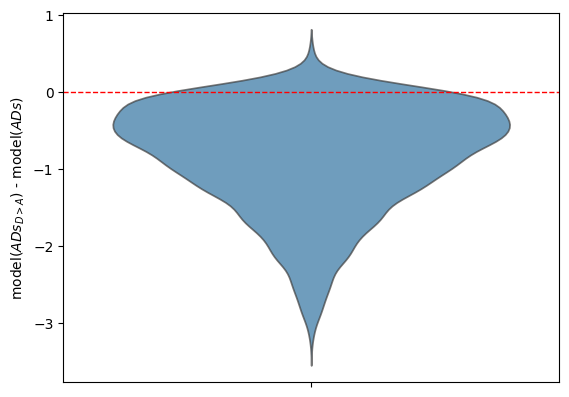

In [30]:
sns.violinplot(mutated_preds - actual_preds, inner=None, alpha=.7)
plt.axhline(0, c='r', linewidth=1, linestyle="--")
plt.ylabel("model($ADs_{D > A}$) - model($ADs$)")
plt.show()

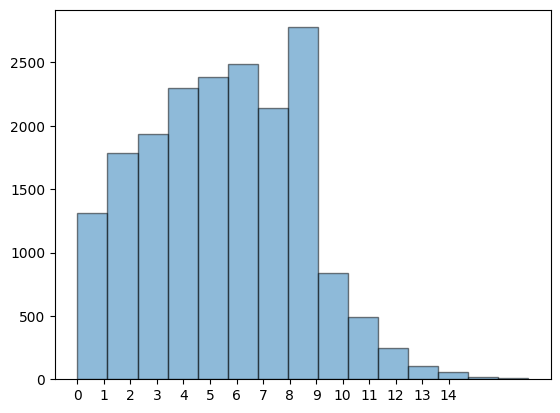

In [31]:
plt.hist(df["Seq"].str.count("S"), bins=15, edgecolor='k', alpha=.5)
plt.xticks(range(15))
plt.show()

# Looking into why D is assigned negative importance

(tensor([0.8988], grad_fn=<ViewBackward0>),
 tensor([0.8138], grad_fn=<ViewBackward0>))

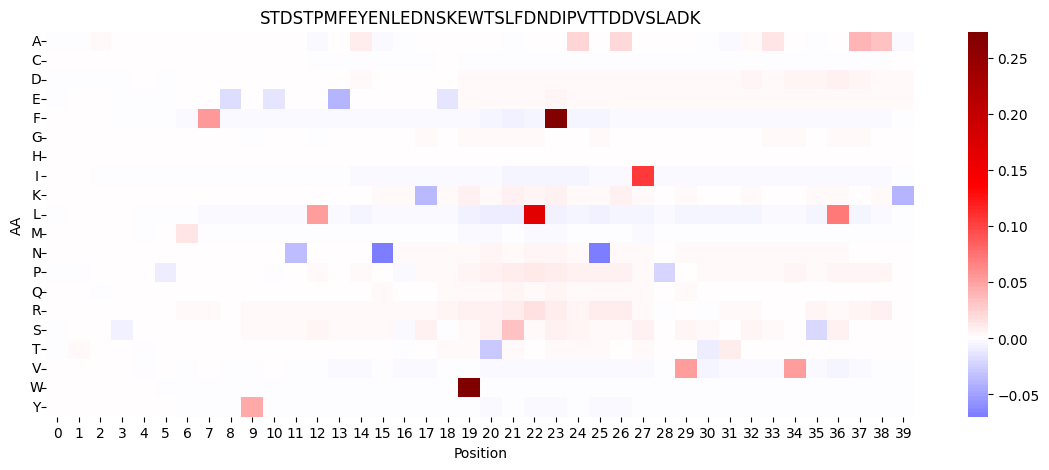

In [32]:
plot_attr(get_attr(dl, model.model.encode(gcn4.replace("D", "A")), baseline_neg), title=gcn4)
model(gcn4.replace("D", "A")), model(gcn4)

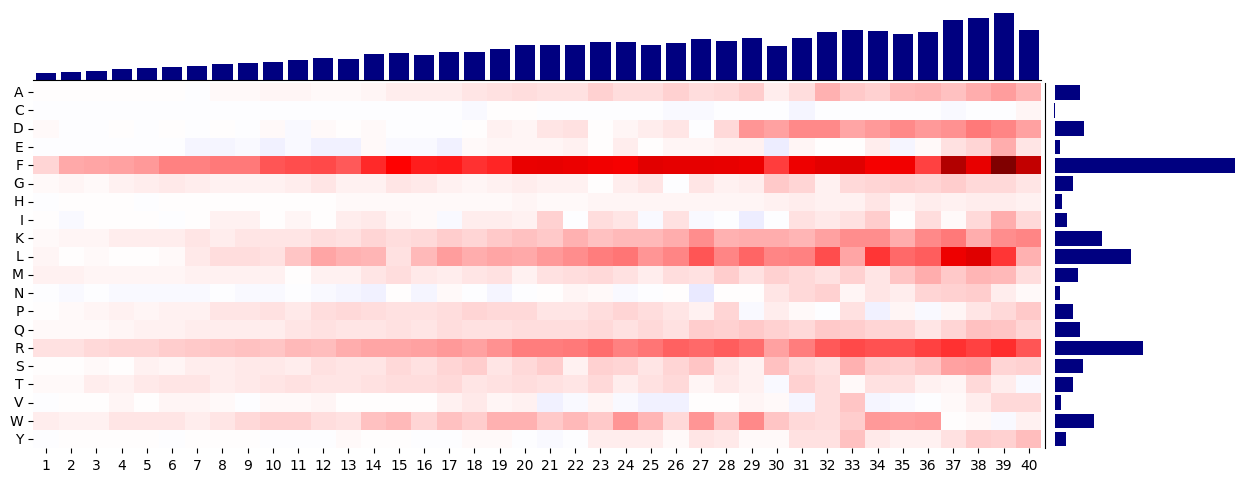

In [33]:
# sns.violinplot(attr.sum(dim=2)[:, 2].detach().numpy())
# plt.show()
attr_d_important = attr[attr.sum(dim=1)[:, 2] > 0].detach().numpy()
d_important_df = pd.DataFrame(attr_d_important.mean(axis=0)).T
d_important_df.index = list(alphabet)
joint_plot(d_important_df)
# plt.show()
# (attr.sum(dim=2)[:, 2].detach().numpy() > 0).shape

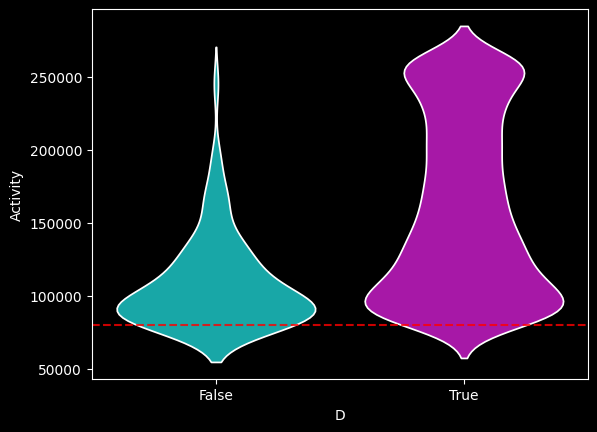

In [34]:
df_ad.loc[df_ad["Seq"].str.contains("D"), "D"] = True
df_ad.loc[~df_ad["Seq"].str.contains("D"), "D"] = False
with plt.style.context("dark_background"):
    sns.violinplot(df_ad, x="D", y="Activity", inner=None, hue="D", palette=['c', 'm'], edgecolor='w', legend=False)
    plt.axhline(thresh, c='r', linestyle="--", alpha=0.8)
    plt.show()

In [35]:
pred_d_ads = model(
    (torch.tensor(
        df_ad.loc[df_ad["D"], "Seq"].apply(
            lambda seq: [[aa_to_i[i] for i in seq]]).values.tolist())).squeeze()).squeeze().detach().numpy()
pred_dtoa_ads = model(
    (torch.tensor(
        df_ad.loc[df_ad["D"], "Seq"].str.replace("D", "A").apply(
            lambda seq: [[aa_to_i[i] for i in seq]]).values.tolist())).squeeze()).squeeze().detach().numpy()

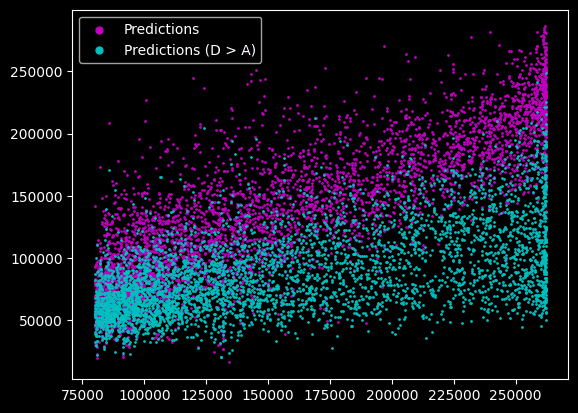

In [36]:
actual_d_ads = df_ad.loc[df_ad["D"], "Activity"].values
with plt.style.context("dark_background"):
    plt.scatter(actual_d_ads, scaler.inverse_transform(pred_d_ads.reshape(-1, 1)).flatten(), c='m', label="Predictions", s=1)
    plt.scatter(actual_d_ads, scaler.inverse_transform(pred_dtoa_ads.reshape(-1, 1)).flatten(), c='c', label="Predictions (D > A)", s=1)
    # plt.scatter(actual_d_ads, scaler.inverse_transform((pred_d_ads - pred_dtoa_ads).reshape(-1, 1)).flatten(), c='c', label="Predictions (D > A)", s=1)
    plt.legend(markerscale=5)
    plt.show()

In [37]:
from Bio.SeqUtils.IsoelectricPoint import IsoelectricPoint

def charge_ctr(seq):
    pos = seq.count("R") + seq.count("K")
    neg = seq.count("D") + seq.count("E")
    return pos - neg
# IsoelectricPoint(df["Seq"][0])
df["Seq"].apply(lambda seq: IsoelectricPoint(seq).charge_at_pH(7.0))
# df["Seq"][0].count("R", "K")

# df["Seq"].apply(charge_ctr)

0        2.505038
1        1.837712
2        1.761995
3        2.794957
4        2.759184
           ...   
18891    6.744086
18892    3.809914
18893    3.807926
18894    1.773162
18895   -2.225687
Name: Seq, Length: 18896, dtype: float64

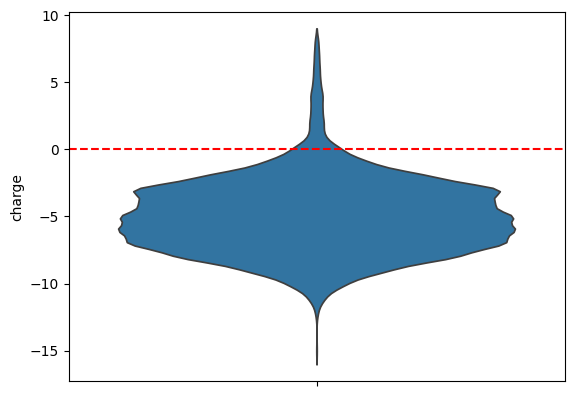

In [38]:
df_ad["charge"] = df["Seq"].apply(lambda seq: IsoelectricPoint(seq).charge_at_pH(7.0))
df_ad["charge"] = df["Seq"].apply(charge_ctr)
sns.violinplot(df_ad["charge"], inner=None)
plt.axhline(0, c='r', linestyle="--")
plt.show()

torch.Size([923, 40, 20])


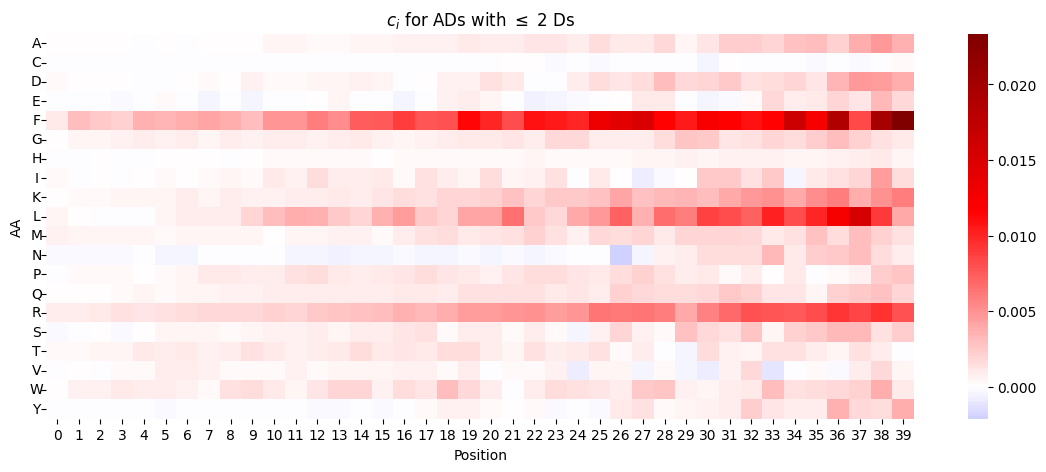

In [39]:
X_ad_2orless_D = torch.stack(df_ad.loc[(df_ad["D"]) & (df_ad["Seq"].str.count("D") <= 2), "Seq"].apply(model.model.encode).tolist()).squeeze()
print(X_ad_2orless_D.shape)
plot_attr(get_attr(dl, X_ad_2orless_D, baseline_neg), title="$c_i$ for ADs with $\leq$ 2 Ds")
plt.show()

tensor([1.0234], grad_fn=<ViewBackward0>)
tensor([9.3979], grad_fn=<ViewBackward0>)


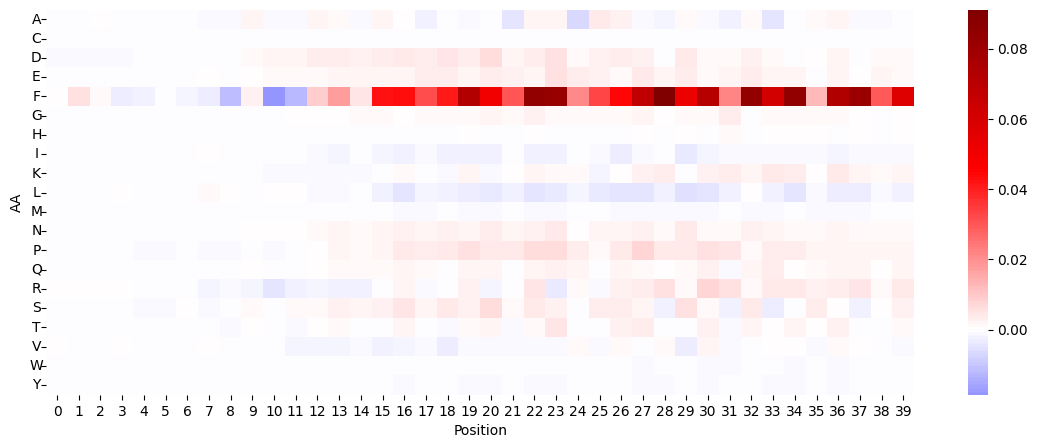

In [40]:
plot_attr(
    get_attr(dl, model.model.encode("F" * 40), baseline_neg)
)
print(model("F" * 40))
print(model("DF" * 20))
plt.show()

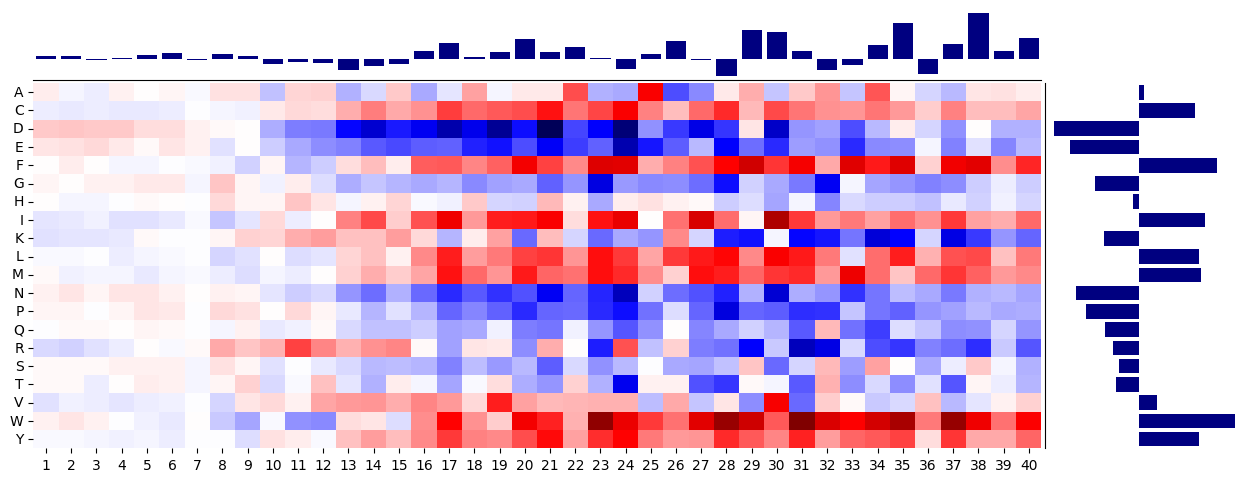

In [41]:
joint_plot(get_attr(dl_m, model.model.encode("F" * 40), baseline_neg))
plt.show()

In [42]:
eval = lambda s: print(f"{s}: {model(s).item()}")
# eval("F" * 40)
# eval("FD" * 20)
# eval("DF" * 20)
# eval("WD" * 20)
# eval("DS" * 20)
# eval("AF" * 20)
for i in alphabet:
    eval(f"{i}F" * 20)
print()
for i in alphabet:
    eval(f"F{i}" * 20)

AFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAFAF: 0.2320186197757721
CFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCFCF: 0.5631123781204224
DFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDFDF: 9.397902488708496
EFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEFEF: 6.238089084625244
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF: 1.0234004259109497
GFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGFGF: 1.0296549797058105
HFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHFHF: 0.12784478068351746
IFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIFIF: 0.65189129114151
KFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKFKF: -0.24126271903514862
LFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLFLF: 0.7266831994056702
MFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMFMF: 0.6719585657119751
NFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNFNF: 4.040959358215332
PFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPFPF: 2.429987668991089
QFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQFQF: 0.8083736896514893
RFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRFRF: -0.11879496276378632
SFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSFSF: 0.7416656613349915
TFTFTFTFTFTFTFTFTFTFTFTFT

## Differences bw D important/unimportant ADs

In [122]:
attr_positional = (X_ad_enc * attr).detach()

In [123]:
charges = (df["Seq"].str.count("R|K") - df["Seq"].str.count("D|E")).values
wfyl = df["Seq"].str.count("W|F|Y|L").values
df["Charge"] = charges
df["WFYL"] = wfyl

In [185]:
baseline_charge = (
    baseline_neg[:, :, [alphabet.index("R"), alphabet.index("K")]].sum(dim=[1, 2]) - \
    baseline_neg[:, :, [alphabet.index("D"), alphabet.index("E")]].sum(dim=[1, 2]))
baseline_charge.item()

0.9185628890991211

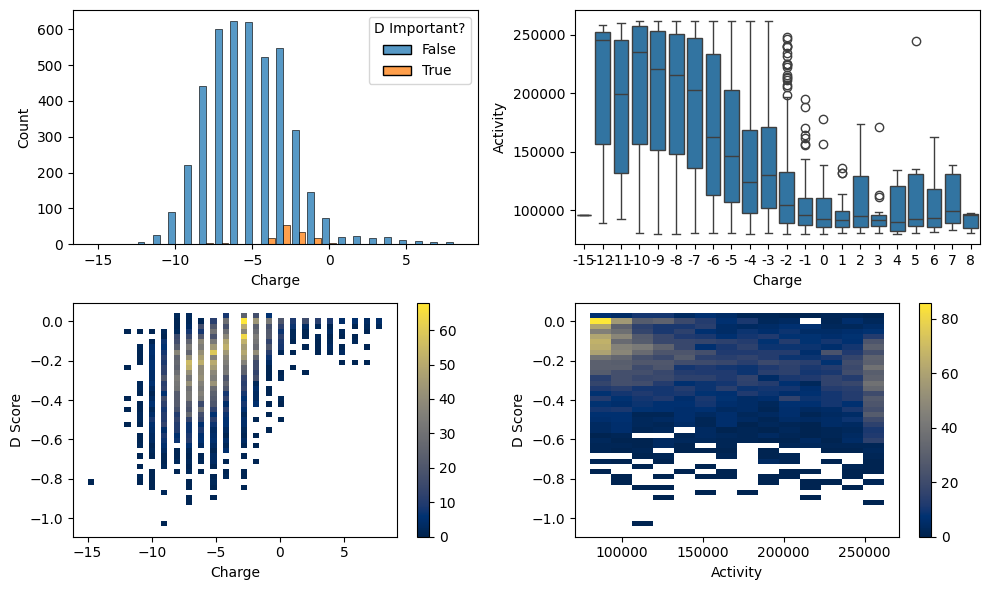

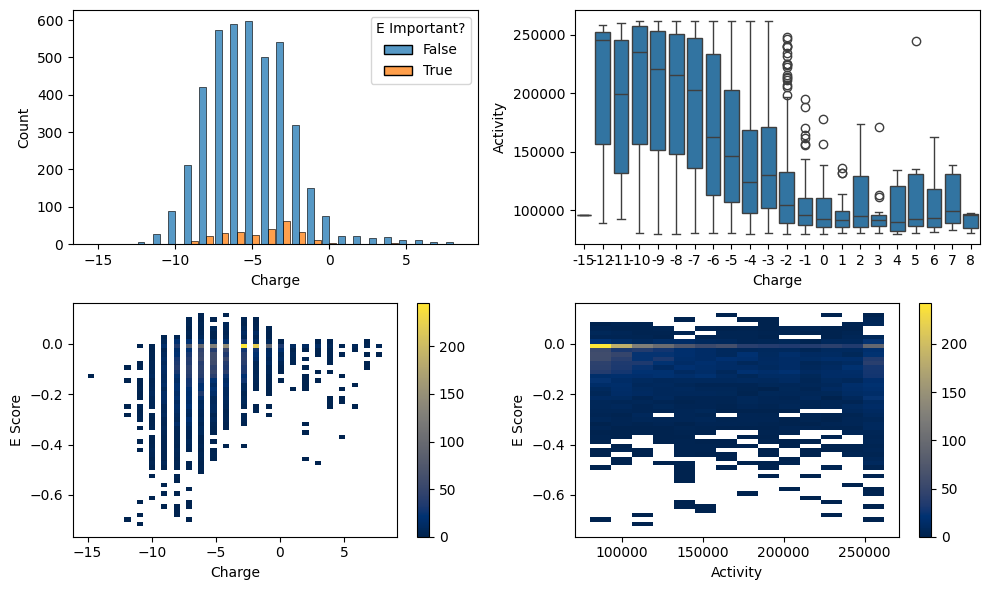

In [172]:
ad_idx = np.where(df["Activity"] >= thresh)[0]
df_ad = df.iloc[ad_idx].copy()
with torch.no_grad():
    d_sums = attr_positional.sum(dim=1)[:, alphabet.index("D")].numpy()
    e_sums = attr_positional.sum(dim=1)[:, alphabet.index("E")].numpy()
df_ad["D Score"] = d_sums
df_ad["E Score"] = e_sums
d_important = "D Important?"
e_important = "E Important?"
df_ad[d_important] = False
df_ad.loc[df_ad.iloc[d_sums > 0].index, d_important] = True
df_ad[e_important] = False
df_ad.loc[df_ad.iloc[e_sums > 0].index, e_important] = True
# sns.violinplot(df_ad, x=d_important, y="Charge", inner=None)
# plt.show()
# sns.violinplot(df_ad, hue=d_important, y="WFYL", inner=None)
# plt.show()

fig, axs = plt.subplots(2, 2, figsize=(10,6))
sns.histplot(df_ad, hue=d_important, x="Charge", multiple="dodge", ax=axs[0, 0], discrete=True, shrink=0.9)
# sns.histplot(df_ad, x="Charge", y="Activity", ax=axs[0, 1], cbar=True, cmap="viridis", )
sns.boxplot(df_ad, x="Charge", y="Activity", ax=axs[0, 1], )
sns.histplot(df_ad, x="Charge", y="D Score", ax=axs[1, 0], cbar=True, cmap="cividis")
# axs[1, 0].axhline(0, c='k', linewidth=1, alpha=0.3)
sns.histplot(df_ad, x="Activity", y="D Score", ax=axs[1, 1], cbar=True, cmap="cividis")

plt.tight_layout()
plt.show()
fig, axs = plt.subplots(2, 2, figsize=(10,6))
sns.histplot(df_ad, hue=e_important, x="Charge", multiple="dodge", ax=axs[0, 0], discrete=True, shrink=0.9)
# sns.histplot(df_ad, x="Charge", y="Activity", ax=axs[0, 1], cbar=True, cmap="viridis", )
sns.boxplot(df_ad, x="Charge", y="Activity", ax=axs[0, 1], )
sns.histplot(df_ad, x="Charge", y="E Score", ax=axs[1, 0], cbar=True, cmap="cividis")
# axs[1, 0].axhline(0, c='k', linewidth=1, alpha=0.3)
sns.histplot(df_ad, x="Activity", y="E Score", ax=axs[1, 1], cbar=True, cmap="cividis")

plt.tight_layout()
plt.show()

# plt.scatter(x=df_ad["Seq"].str.count("D").values, y=df_ad["Charge"])
# plt.scatter(x=df_ad["Seq"].str.count("D").values, y=d_sums)
# plt.scatter(x=df_ad["Charge"], y=d_sums)

Plots:

- Charge vs activity: does activity correlate w charge?
- D score vs charge: are Ds more important at negative charge?
- D score vs activity: are Ds important as you get more active?
- 

In [202]:
with torch.no_grad():
    y_pred = model(torch.tensor(X))
df["Predicted Activity"] = scaler.inverse_transform(y_pred)

In [205]:
# df[['Activity', 'Predicted Activity']].corr(method="spearman")

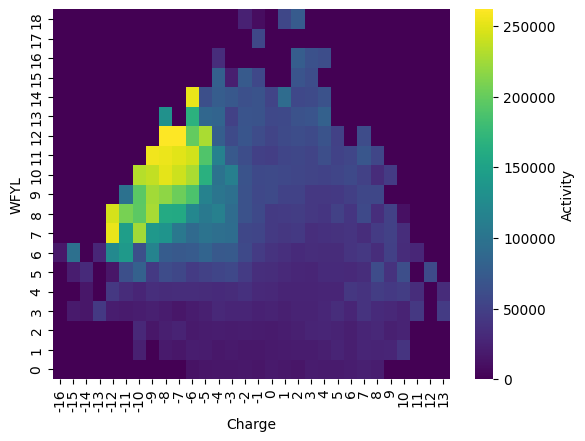

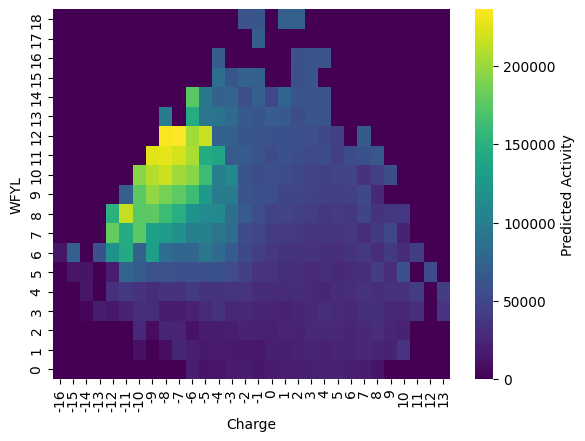

In [211]:
sdf = pd.DataFrame({i: df["Seq"].str.count(i) for i in alphabet})
sdf["WFYL"] = sdf[list('WFYL')].sum(axis=1)
sdf["Charge"] = sdf[['R', 'K']].sum(axis=1) - sdf[['D', 'E']].sum(axis=1)
sdf["Activity"] = df["Activity"]
sdf = sdf.pivot_table(index="WFYL", columns="Charge", values="Activity", aggfunc="median").fillna(0)
# sdf = sdf.pivot_table(index="WFYL", columns="E", values="Activity", aggfunc="mean").fillna(0)
sdf = sdf.sort_index(ascending=False)
sns.heatmap(sdf,cmap="viridis", xticklabels=True, cbar_kws={"label": "Activity"})
# plt.colorbar("Activity")
plt.show()

sdf = pd.DataFrame({i: df["Seq"].str.count(i) for i in alphabet})
sdf["WFYL"] = sdf[list('WFYL')].sum(axis=1)
sdf["Charge"] = sdf[['R', 'K']].sum(axis=1) - sdf[['D', 'E']].sum(axis=1)
sdf["Predicted Activity"] = df["Predicted Activity"]
sdf = sdf.pivot_table(index="WFYL", columns="Charge", values="Predicted Activity", aggfunc="median").fillna(0)
# sdf = sdf.pivot_table(index="WFYL", columns="E", values="Activity", aggfunc="mean").fillna(0)
sdf = sdf.sort_index(ascending=False)
sns.heatmap(sdf,cmap="viridis", xticklabels=True, cbar_kws={"label": "Predicted Activity"})
plt.show()


# Logo stuff

In [1]:
def logo_plot(df, ax=None, title=""):
    if ax is None:
        fig, ax = plt.subplots(dpi=500)
    logo = logomaker.Logo(df,
                            shade_below=.5,
                            fade_below=.5,
                            font_name='Arial Rounded MT Bold',
                            color_scheme="dmslogo_funcgroup",
                            ax=ax)
    logo.style_spines(visible=False)
    logo.style_spines(spines=['left', 'bottom'], visible=True)
    logo.ax.axhline(0, c='r', linewidth=1)
    logo.ax.set_title(title)
    return logo.ax

with plt.style.context("dark_background"):
    logo_plot((gcn4_mult_null * np.abs(dxn_df)).T)
    plt.show()

NameError: name 'plt' is not defined

In [44]:
def gene_importance_scores(df, gene, dl, baseline, model=model, delta_transform=False):   
    """
    Calculates importance scores for each AA / position along an entire gene, 
    averaging the importance scores between AA positions present in multiple
    40aa sequence windows. Assumes df and model are already defined. 
    
    Args:
        gene : Gene name in df
        dl: DeepLIFT attribution object
        baseline: Tensor corresponding to baseline for DeepLIFT
        model: Model to use. Defaults to predefined model.
        delta_transform: Whether or not to multiply deeplift outputs by ∆x for each input. 
            Defaults to False; only use true if DeepLIFT object is configured to return 
            multipliers (multiply_by_inputs=False). 
    """
    
    df_gene = df[df["SpeciesNames"] == gene].copy()
    X_gene = torch.stack(list(df_gene["Seq"].apply(model.model.encode).values)).squeeze()
    # It's useful and quick to store ADHunter predictions in df_gene:
    with torch.no_grad():
        predicted_activity = model(X_gene).detach().numpy()
        # Need to unscale the predicted activity values
        activities_measured = df["Activity"].values.reshape(-1, 1)
        scaler = preprocessing.StandardScaler().fit(activities_measured)
        predicted_activity = scaler.inverse_transform(
            predicted_activity.reshape(-1, 1)
            ).flatten()
        df_gene["Predicted Activity"] = predicted_activity
    # Now let's do DeepLIFT:
    X_scores = dl.attribute(
        X_gene, baselines=baseline, attribute_to_layer_input=True
        ).detach().numpy()
    if delta_transform:
        deltas = (X_gene - baseline_neg).detach().numpy()
        X_scores = X_scores * deltas
    xdfs = []
    for idx, scores in enumerate(X_scores):
        xdf = pd.DataFrame(scores).T
        xdf.columns += df_gene.iloc[idx]["NativeLocation"]
        # Subtract 20 to reflect the fact that positions are the centers of the AD
        xdf.columns -= 20
        xdf.index = list(alphabet)
        xdfs.append(xdf)
    M = pd.concat(xdfs, axis=1)
    M_bar = M.T.groupby(M.columns).mean().T
    M_std = M.T.groupby(M.columns).std().T.fillna(0)
    return df_gene, M_bar, M_std

In [45]:
# df_gene = df[df["SpeciesNames"] == gene].copy()
# X_gene = torch.stack(list(df_gene["Seq"].apply(model.model.encode).values)).squeeze()
# # It's useful and quick to store ADHunter predictions in df_gene:
# with torch.no_grad():
#     predicted_activity = model(X_gene).detach().numpy()
#     # Need to unscale the predicted activity values
#     activities_measured = df["Activity"].values.reshape(-1, 1)
#     scaler = preprocessing.StandardScaler().fit(activities_measured)
#     predicted_activity = scaler.inverse_transform(
#         predicted_activity.reshape(-1, 1)
#         ).flatten()
#     df_gene["Predicted Activity"] = predicted_activity
# # Now let's do DeepLIFT:
# X_scores = dl.attribute(
#     X_gene, baselines=baseline, attribute_to_layer_input=True
#     ).detach().numpy()
# if delta_transform:
#     print("!")
#     deltas = (X_gene - baseline_neg).detach().numpy()
#     X_scores_ = X_scores * deltas
# xdfs = []
# for idx, scores in enumerate(X_scores):
#     xdf = pd.DataFrame(scores).T
#     xdf.columns += df_gene.iloc[idx]["NativeLocation"]
#     # Subtract 20 to reflect the fact that positions are the centers of the AD
#     xdf.columns -= 20
#     xdf.index = list(alphabet)
#     xdfs.append(xdf)
# M = pd.concat(xdfs, axis=1)
# M_bar = M.T.groupby(M.columns).mean().T
# M_std = M.T.groupby(M.columns).std().T.fillna(0)


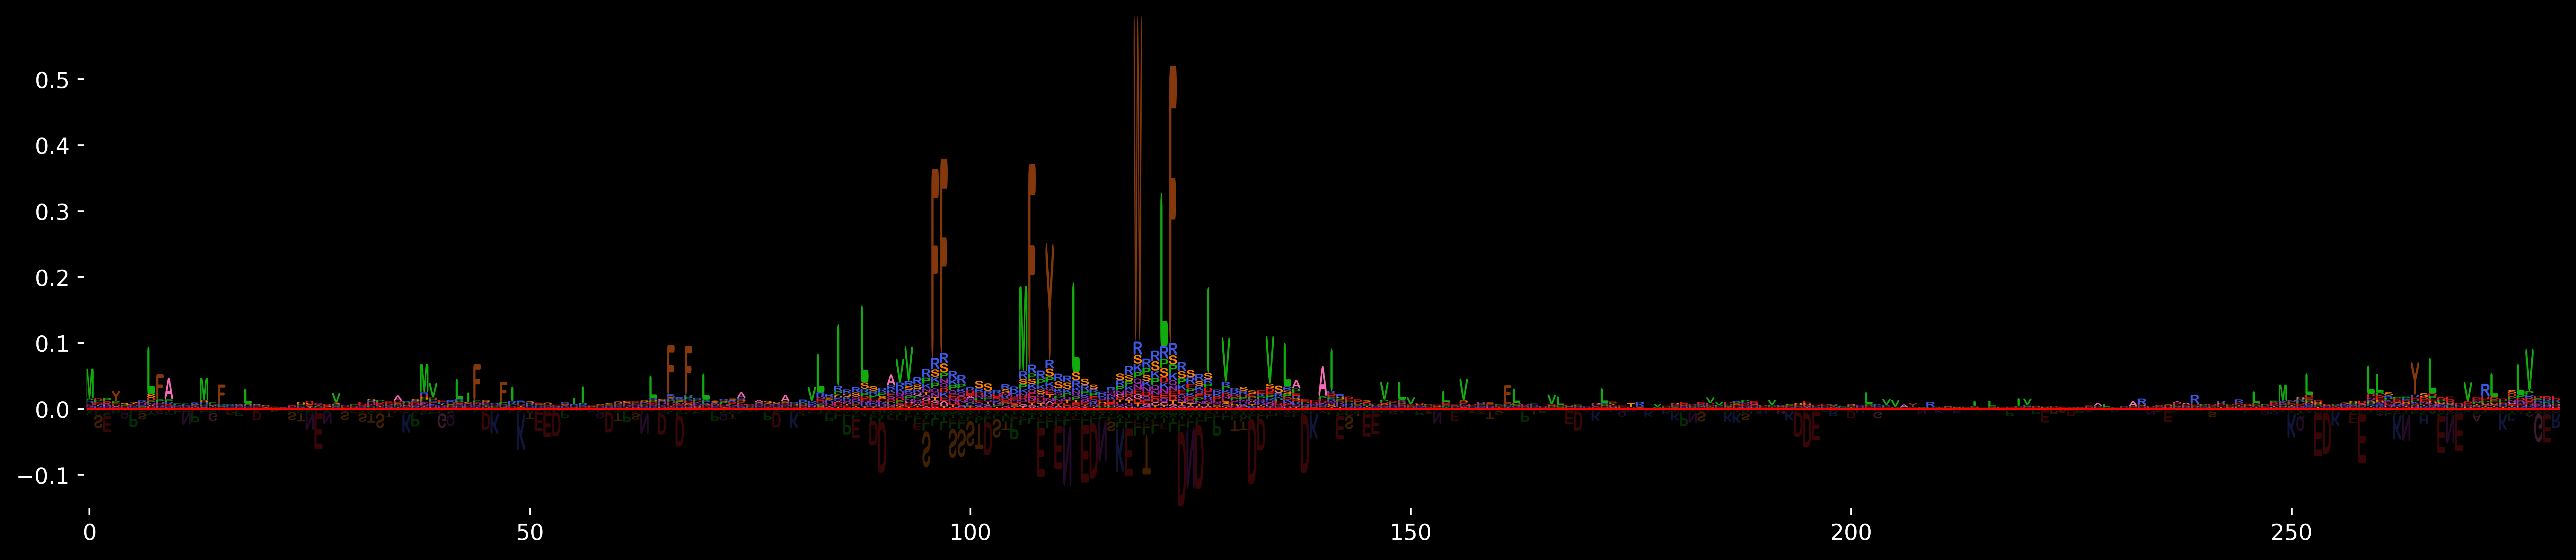

In [46]:
gcn4_speciesname = df.loc[df["Seq"] == gcn4, "SpeciesNames"].item()
df_gene, M_bar, M_std = gene_importance_scores(
    df, gcn4_speciesname, dl_m, baseline_neg, delta_transform=True)
with plt.style.context("dark_background"):
    fig, ax = plt.subplots(figsize=(20, 4), dpi=500)
    logo_plot(M_bar.T, ax=ax)
    plt.show()

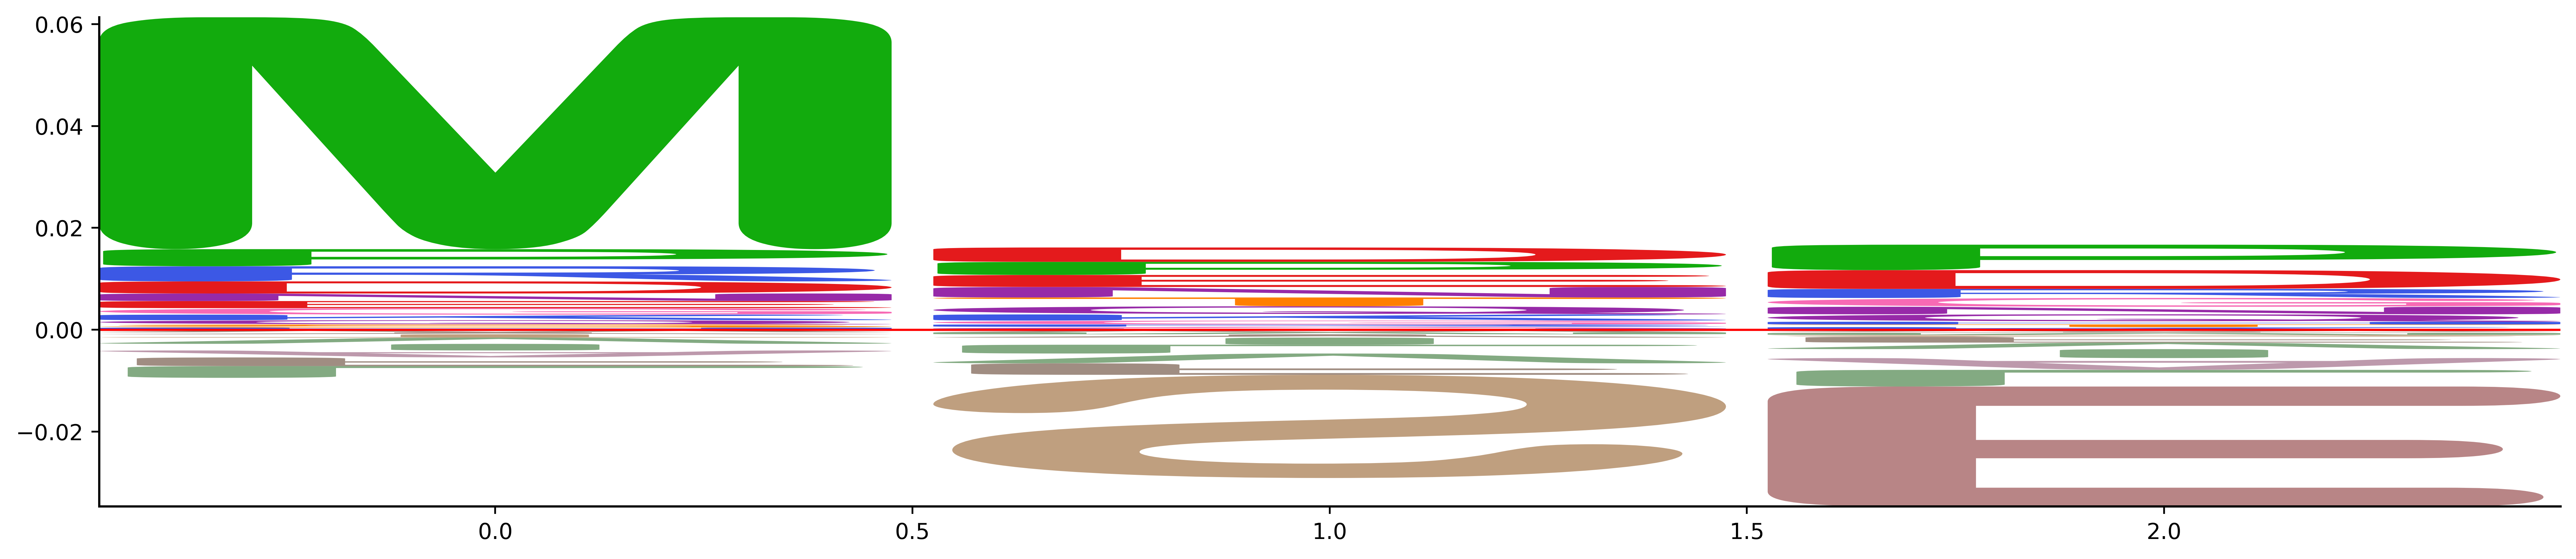

In [47]:
fig, ax = plt.subplots(figsize=(20, 4), dpi=500)
ax = logo_plot(M_bar.iloc[:, :3].T, ax=ax)

ax.plot(range(3), np.ones(3), linewidth=100)
plt.show()

In [48]:
df_gene[df_gene["Seq"].str.contains("MF.Y..L")]

,Unnamed: 0,SpeciesNames,NativeLocation,NormLocation,Seq,Activity,Stdev_BYS4_BioReps,Set,charge,acidic,s_rich,p_rich,Predicted Activity
15538,80681,Saccharomycotina_sp|P03069|GCN4_YEAST,95,-24,TAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLED,140520.174016,NaN,train,-9,True,False,False,148676.703125
15539,80682,Saccharomycotina_sp|P03069|GCN4_YEAST,100,-19,KTVLPIPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEW,204748.126621,NaN,train,-8,True,True,False,170587.546875
15540,80683,Saccharomycotina_sp|P03069|GCN4_YEAST,105,-14,IPELDDAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFD,181674.784117,113260.023304,train,-10,True,True,False,214796.609375
15541,80684,Saccharomycotina_sp|P03069|GCN4_YEAST,110,-9,DAVVESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPV,262002.863007,NaN,train,-9,True,True,False,210307.828125
15542,80685,Saccharomycotina_sp|P03069|GCN4_YEAST,115,-4,SFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDV,207789.413988,NaN,train,-9,True,True,False,170595.640625
15543,80686,Saccharomycotina_sp|P03069|GCN4_YEAST,120,1,STDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADK,137982.570130,20750.905186,train,-9,True,False,False,116193.648438
15544,80687,Saccharomycotina_sp|P03069|GCN4_YEAST,125,6,PMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIEST,169040.952358,24810.975568,train,-9,True,False,False,124095.703125
15574,80723,Saccharomycotina_sp|P03069|GCN4_YEAST,113,-6,VESFFSSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTD,193043.297482,91717.518960,train,-9,True,True,False,180322.140625
15575,80724,Saccharomycotina_sp|P03069|GCN4_YEAST,118,-1,SSSTDSTPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLA,167410.937504,NaN,train,-9,True,True,False,148428.171875
15576,80725,Saccharomycotina_sp|P03069|GCN4_YEAST,123,4,STPMFEYENLEDNSKEWTSLFDNDIPVTTDDVSLADKAIE,138270.965613,6950.885872,train,-9,True,False,False,126095.585938


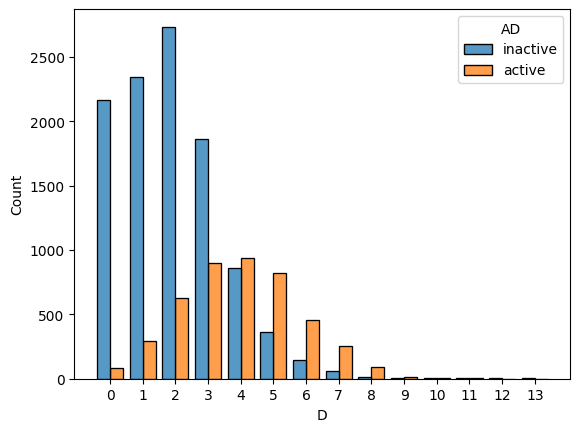

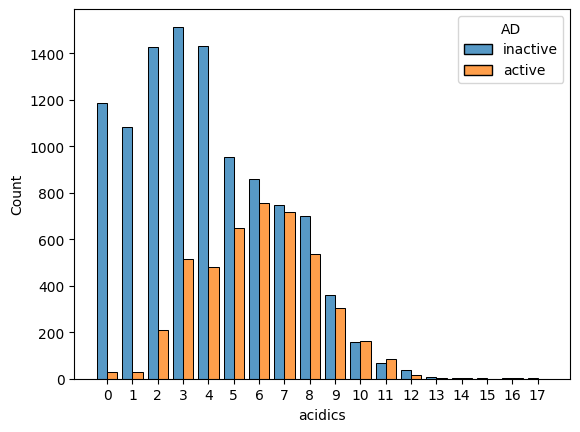

In [49]:
df.loc[df["Activity"] >= thresh, "AD"] = "active"
df.loc[df["Activity"] <= thresh_neg, "AD"] = "inactive"
df_classified = df.dropna(subset="AD").copy()
df_classified["D"] = df_classified["Seq"].str.count("D")
sns.histplot(df_classified, x="D", hue="AD", binwidth=1, multiple="dodge", discrete=True, shrink=.8)
plt.xticks(range(int(df_classified["D"].min()), int(df_classified["D"].max()) + 1))
plt.show()
df_classified["acidics"] = df_classified["Seq"].str.count("D") + df_classified["Seq"].str.count("E")
sns.histplot(df_classified, x="acidics", hue="AD", binwidth=1, multiple="dodge", discrete=True, shrink=.8)
plt.xticks(range(int(df_classified["acidics"].min()), int(df_classified["acidics"].max()) + 1))
plt.show()